## VAR Monte Carlo
11/14/24

Some simple explorations of Monte-Carlo simulation.


VAR can mean vector auto-regression model, or it can mean value at Risk.  

First we look at value at risk calculations via Monte Carlo simulations, taken from this [blog post](
https://www.pyquantnews.com/the-pyquant-newsletter/quickly-compute-value-at-risk-with-monte-carlo)

Later in the notebook we examine a simple vector autorergression model.  
By repeatedly simulating the VAR model with random error terms, you can create a large set of potential future paths for all variables in the system, providing insights into the range of possible outcomes and their probabilities.

In [1]:
import numpy as np
import pandas as pd
from openbb import obb

In [2]:
sectors = [
    "XLE", 
    "XLF", 
    "XLU", 
    "XLI", 
    "GDX", 
    "XLK", 
    "XLV", 
    "XLY", 
    "XLP", 
    "XLB", 
    "XOP", 
    "IYR", 
    "XHB", 
    "ITB", 
    "VNQ", 
    "GDXJ", 
    "IYE", 
    "OIH", 
    "XME", 
    "XRT", 
    "SMH", 
    "IBB", 
    "KBE", 
    "KRE", 
    "XTL", 
]

data = obb.equity.price.historical(
    sectors, 
    start_date="2022-01-01", 
    provider="yfinance"
).to_df()

In [3]:
# compute the historic mean returns, weights, and covariance matrix.
data["returns"] = data.groupby("symbol").close.pct_change()

portfolio_stats = data.groupby("symbol").agg(
    daily_returns=("returns", "mean"),
)

portfolio_stats["weights"] = 1 / len(sectors)

covariance_matrix = (
    data
    .pivot(
        columns="symbol", 
        values="returns"
    )
    .dropna()
    .cov()
)


In [8]:
portfolio_stats

,daily_returns,weights
symbol,,
GDX,0.000429,0.04
GDXJ,0.000453,0.04
IBB,-0.000003,0.04
ITB,0.000728,0.04
IYE,0.000800,0.04
IYR,-0.000131,0.04
KBE,0.000277,0.04
KRE,0.000084,0.04
OIH,0.000838,0.04


simple average of past returns to represent future expected returns. We also use a static, equal weighted portfolio. From our returns, we can use pandas to compute the covariance matrix between the sector historic returns. We’ll use the covariance matrix in the Monte Carlo to simulate the covariance between assets in the future price paths.

Set up the Monte Carlo simulation
Now that we have our historical returns and covariance matrix, we can generate the simulated price paths.

In [12]:
simulations = 1000
days = len(data.index.unique())
initial_capital = 100000

portfolio = np.zeros((days, simulations))

historical_returns = np.full(
    shape=(days, len(sectors)), 
    fill_value=portfolio_stats.daily_returns
)

In [14]:
days

722

In [5]:
L = np.linalg.cholesky(covariance_matrix)

for i in range(0, simulations):
    Z = np.random.normal(size=(days, len(sectors)))
    daily_returns = historical_returns + np.dot(L, Z.T).T
    portfolio[:, i] = (
        np.cumprod(np.dot(daily_returns, portfolio_stats.weights) + 1) * initial_capital
    )

simulated_portfolio = pd.DataFrame(portfolio)

we calculate the Cholesky decomposition of the covariance matrix. Sounds complicated but all it does is generate correlated random variables. In the loop, we generate a normally distributed random variable and adjust it by the Cholesky factor to simulate daily returns.

These returns are then used to calculate our cumulative portfolio returns over the time period for each simulation. Finally, we use the NumPy array output to construct a pandas DataFrame.

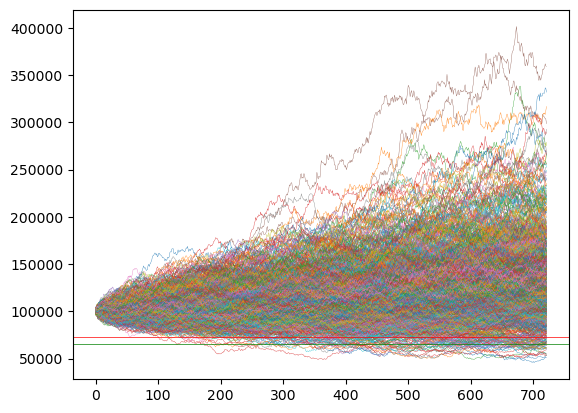

In [6]:
alpha = 5

def montecarlo_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return np.percentile(sim_val, alpha)

def conditional_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return sim_val[sim_val <= montecarlo_var(alpha)].mean()

mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)

ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")

The plot visualizes all price paths, VaR, and CVaR. We can see that CVaR (the green line) is less than VaR which demonstrates the more conservative calculation.

Next steps
This simulation assumes static expected returns, no drift, no volatility, and a static covariance matrix. As a next step, use a look back window for the covariance matrix. You can also try introducing drift and volatility into the price paths.

GEMINI:

You're looking to structure a Vector Autoregression (VAR) model to predict PV output based on temperature, solar irradiance, and their inherent time series dynamics. Here's a possible structure, incorporating the day of the year and ARIMA processes:

**1. Variables**

*  `Temp(t)`: Temperature at time t (e.g., daily average temperature)
*  `Irrad(t)`: Solar irradiance at time t (e.g., daily average irradiance)
*  `PV(t)`: PV output at time t (e.g., daily energy production)

**2.  Day of Year Effect**

*  Include deterministic terms to capture the seasonal patterns:
    *  `sin(2πt/365)`: Captures the annual sinusoidal cycle.
    *  `cos(2πt/365)`: Captures the annual cosine cycle.

**3. ARIMA Structure**

*  Assume `Temp(t)` and `Irrad(t)` each follow an ARIMA(p, d, q) process. You'll need to determine the appropriate orders (p, d, q) based on your data.
*  For example, an ARIMA(1, 0, 1) model for temperature would look like:
    *  `Temp(t) = c + φ₁Temp(t-1) + θ₁ε(t-1) + ε(t)`
    *  Where:
        *  `c` is a constant.
        *  `φ₁` is the autoregressive coefficient.
        *  `θ₁` is the moving average coefficient.
        *  `ε(t)` is white noise.

**4. VAR Equations**

*  Combine the day of year effect and ARIMA structure into a VAR model:

    ```
    Temp(t) = c₁ + a₁₁sin(2πt/365) + a₁₂cos(2πt/365) + φ₁₁Temp(t-1) + ... + φ₁ₚTemp(t-p) + θ₁₁ε₁(t-1) + ... + θ₁qε₁(t-q) +  β₁₁Irrad(t-1) + ... + β₁ᵣIrrad(t-r) + ε₁(t) 

    Irrad(t) = c₂ + a₂₁sin(2πt/365) + a₂₂cos(2πt/365) + φ₂₁Irrad(t-1) + ... + φ₂ₚIrrad(t-p) + θ₂₁ε₂(t-1) + ... + θ₂qε₂(t-q) + β₂₁Temp(t-1) + ... + β₂ᵣTemp(t-r) + ε₂(t)

    PV(t) = c₃ + a₃₁sin(2πt/365) + a₃₂cos(2πt/365) + γ₁Temp(t) + γ₂Irrad(t) + ε₃(t)
    ```

*  Where:
    *  `c₁, c₂, c₃` are constants.
    *  `aᵢⱼ` are coefficients for the day of year effect.
    *  `φᵢⱼ` are autoregressive coefficients.
    *  `θᵢⱼ` are moving average coefficients.
    *  `βᵢⱼ` are coefficients capturing the influence of the other variable in the VAR.
    *  `γ₁, γ₂` are coefficients relating temperature and irradiance to PV output.
    *  `ε₁(t)`, `ε₂(t)`, `ε₃(t)` are white noise terms (potentially correlated).
    *  `p`, `q`, `r` are the ARIMA and lag orders, respectively.

**5. Estimation and Simulation**

*  Estimate the parameters of the VAR model using historical data for temperature, irradiance, and PV output.
*  Use the estimated VAR model to perform Monte Carlo simulations, generating many possible future paths of the variables.
*  Analyze the simulated PV output to estimate its variability and design the insurance product.

**Important Notes**

*  **Lag Order Selection:**  Determine the appropriate lag orders (`p`, `q`, `r`) using information criteria (AIC, BIC) or other model selection techniques.
*  **Correlation:**  Consider the potential correlation between the error terms (`ε₁(t)`, `ε₂(t)`, `ε₃(t)`) in the VAR model.
*  **Model Diagnostics:**  After estimating the model, perform diagnostic checks to ensure the model assumptions are met (e.g., residuals are white noise).
*  **Software:**  Use statistical software packages like R or Python (with libraries like `statsmodels`) to estimate and simulate VAR models.

This VAR structure provides a framework for modeling the relationship between temperature, irradiance, and PV output, incorporating seasonality and time series dynamics. By using this model in Monte Carlo simulations, you can gain valuable insights for designing your insurance product.


In [16]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

# --- Load and Prepare Data ---
# Assume you have a DataFrame called 'df' with columns 'Temp', 'Irrad', and 'PV'

# Add day of year as a variable
df['DayOfYear'] = df.index.dayofyear  # Assuming your DataFrame has a datetime index

# Create lagged variables (adjust lags as needed)
df['Temp_Lag1'] = df['Temp'].shift(1)
df['Irrad_Lag1'] = df['Irrad'].shift(1)

# --- Fit VAR Model ---
# Select the appropriate lag order (p) based on your data
model = VAR(df[['Temp', 'Irrad', 'PV']])
results = model.fit(maxlags=p)  

# --- Extract Model Parameters ---
# Get the estimated coefficients, covariance matrix of residuals, etc.
coefs = results.coefs
resid_cov = results.resid_cov

# --- Monte Carlo Simulation ---
n_simulations = 1000  # Number of simulations
forecast_horizon = 365  # Forecast horizon (e.g., one year)

# Initialize arrays to store simulated values
simulated_temp = np.zeros((n_simulations, forecast_horizon))
simulated_irrad = np.zeros((n_simulations, forecast_horizon))
simulated_pv = np.zeros((n_simulations, forecast_horizon))

# Loop through simulations
for i in range(n_simulations):
    # Generate random shocks from multivariate normal distribution
    shocks = np.random.multivariate_normal(np.zeros(3), resid_cov, forecast_horizon)

    # Initialize starting values (e.g., last observed values)
    temp_sim = df['Temp'].iloc[-1]
    irrad_sim = df['Irrad'].iloc[-1]
    pv_sim = df['PV'].iloc[-1]

    # Simulate temperature and irradiance using VAR model and shocks
    for t in range(forecast_horizon):
        # Day of year effect (adjust formula as needed)
        day_of_year_effect = np.array([
            np.sin(2 * np.pi * (df['DayOfYear'].iloc[-1] + t) / 365),
            np.cos(2 * np.pi * (df['DayOfYear'].iloc[-1] + t) / 365)
        ])

        # Calculate predicted values using VAR coefficients and lagged values
        temp_pred = (
            coefs[0, 0, 0] * temp_sim 
            + coefs[0, 1, 0] * irrad_sim 
            + coefs[0, 0, 1] * df['Temp_Lag1'].iloc[-1]  # Add more lags as needed
            + coefs[0, 1, 1] * df['Irrad_Lag1'].iloc[-1]  # Add more lags as needed
            + np.dot(coefs[0, :, 2:], day_of_year_effect)  # Day of year effect
            + shocks[t, 0]  # Add shock
        )

        irrad_pred = (
            coefs[1, 0, 0] * temp_sim 
            + coefs[1, 1, 0] * irrad_sim 
            + coefs[1, 0, 1] * df['Temp_Lag1'].iloc[-1]  # Add more lags as needed
            + coefs[1, 1, 1] * df['Irrad_Lag1'].iloc[-1]  # Add more lags as needed
            + np.dot(coefs[1, :, 2:], day_of_year_effect)  # Day of year effect
            + shocks[t, 1]  # Add shock
        )

        # Predict PV output
        pv_pred = (
            coefs[2, 0, 0] * temp_pred
            + coefs[2, 1, 0] * irrad_pred
            + np.dot(coefs[2, :, 2:], day_of_year_effect)  # Day of year effect
            + shocks[t, 2]  # Add shock
        )

        # Store simulated values
        simulated_temp[i, t] = temp_pred
        simulated_irrad[i, t] = irrad_pred
        simulated_pv[i, t] = pv_pred

        # Update lagged values for next iteration
        temp_sim = temp_pred
        irrad_sim = irrad_pred

# --- Analyze Simulated PV Output ---
# Calculate percentiles, probabilities of low output, etc.
pv_output_percentiles = np.percentile(simulated_pv, [5, 25, 50, 75, 95], axis=0)

# Plot the percentiles of simulated PV output
plt.figure(figsize=(10, 6))
plt.plot(pv_output_percentiles.T)
plt.xlabel('Day')
plt.ylabel('PV Output')
plt.title('Percentiles of Simulated PV Output')
plt.legend(['5th', '25th', '50th', '75th', '95th'])
plt.show()

# --- Design and Price Insurance Product ---
# ... (Use the simulated_pv data to design and price the insurance as described earlier)

NameError: name 'df' is not defined